In [36]:
import pandas as pd
import numpy as np
import os
from os import listdir
from PIL import Image
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

In [37]:
import os
src = 'E:\data'
waste_types = os.listdir(src)
waste_types

['LICENSE.md',
 'Brown box',
 'Chopstick Covers',
 'Chopsticks',
 'Foil',
 'Food',
 'Paper Bowl',
 'Paper Bowl Small',
 'Paper Bowl Square',
 'Plastic Cover',
 'Plastic Cup',
 'Plastic Lid',
 'Plastic Utensil',
 'Sauce Cup',
 'Sauce Packets',
 'Straw',
 'Tissue Paper']

In [38]:

# Image and batch settings
image_size = (224, 224)
batch_size = 16

# Load training dataset
train_ds = image_dataset_from_directory(
    src,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=133,
    validation_split=0.2,  # 20% of data for validation
    subset="training",  # Specify training subset
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    src,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=133,
    validation_split=0.2,
    subset="validation",  # Specify validation subset
)

# Check dataset structure
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)


Found 543 files belonging to 16 classes.
Using 435 files for training.
Found 543 files belonging to 16 classes.
Using 108 files for validation.
(16, 224, 224, 3) (16,)


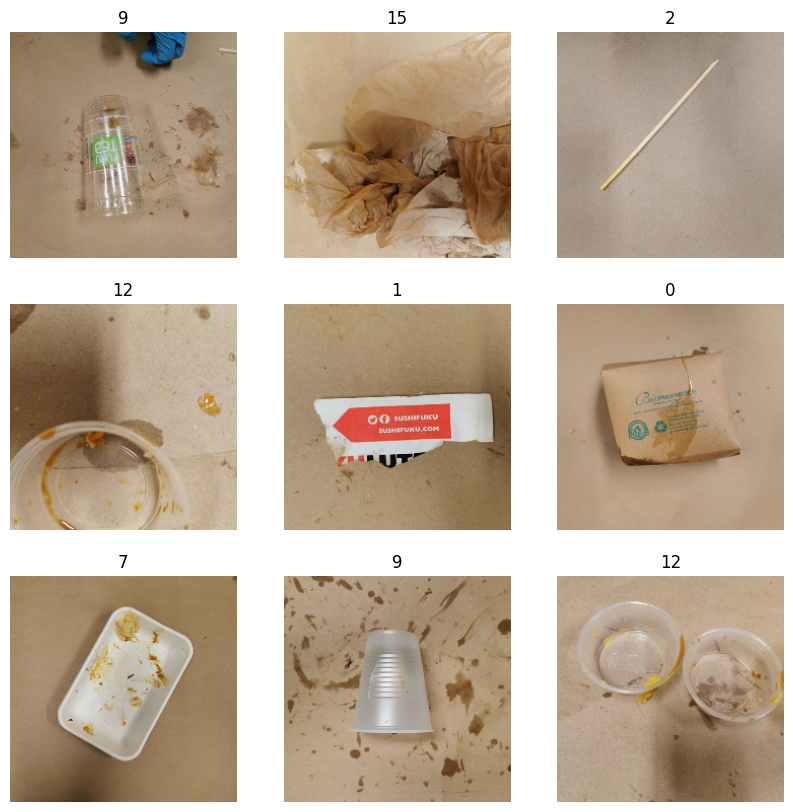

In [39]:
# Visualize the data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [40]:
# Using image data augmentation

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

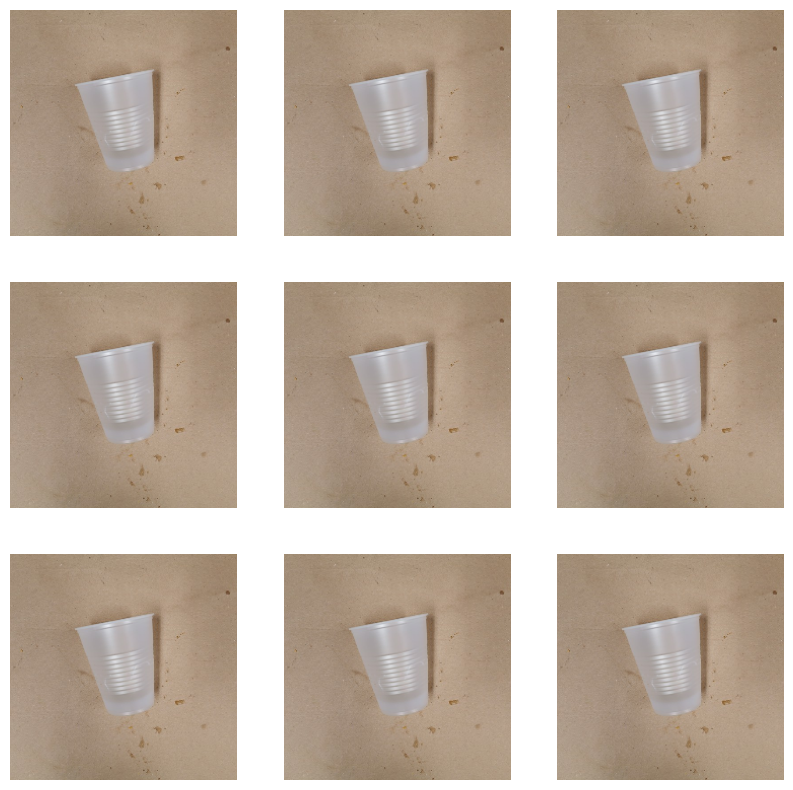

In [41]:
# Visuvalize data augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [42]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 16

def make_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)  # Use 'Input' instead of 'InputLayer'

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Final separable convolution
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # GlobalAveragePooling instead of Flatten
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)

    # Output layer
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dense(units=256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x) 
    x = layers.Dense(units=128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x) 
    x = layers.Dense(units=64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)  # Dropout to prevent overfitting
    outputs = layers.Dense(units, activation=activation)(x)

    # Create the model
    model = models.Model(inputs, outputs)
    return model

# Example to create the model
input_shape = (224,224, 3)
model = make_model(input_shape, num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 12  3584        ['rescaling_2[0][0]']            
                                8)                                                                
                                                                                            

In [45]:
#keras.utils.plot_model(model, show_shapes=True)

In [46]:
# 5. Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

# 6. Train the model
history = model.fit(train_ds, epochs=1000, validation_data=val_ds)

# 7. Evaluate the model
loss, accuracy = model.evaluate(val_ds)

Epoch 1/1000
28/28 [==============================] - 9s 194ms/step - loss: 2.6995 - accuracy: 0.1540 - val_loss: 2.7523 - val_accuracy: 0.1019
Epoch 2/1000
28/28 [==============================] - 5s 176ms/step - loss: 2.4198 - accuracy: 0.2345 - val_loss: 2.7264 - val_accuracy: 0.1019
Epoch 3/1000
28/28 [==============================] - 5s 176ms/step - loss: 2.1475 - accuracy: 0.3172 - val_loss: 2.7258 - val_accuracy: 0.1019
Epoch 4/1000
28/28 [==============================] - 5s 177ms/step - loss: 1.9582 - accuracy: 0.3655 - val_loss: 2.7848 - val_accuracy: 0.1019
Epoch 5/1000
28/28 [==============================] - 5s 176ms/step - loss: 2.0919 - accuracy: 0.3287 - val_loss: 2.8826 - val_accuracy: 0.1019
Epoch 6/1000
28/28 [==============================] - 5s 177ms/step - loss: 1.9914 - accuracy: 0.3517 - val_loss: 3.2238 - val_accuracy: 0.1019
Epoch 7/1000
28/28 [==============================] - 5s 176ms/step - loss: 1.7979 - accuracy: 0.4046 - val_loss: 3.0863 - val_accuracy:

In [47]:
model.save("my_model.h5")

In [48]:
# Load the saved model
loaded_model = tf.keras.models.load_model("my_model.h5")

# Check model summary
loaded_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 12  3584        ['rescaling_2[0][0]']            
                                8)                                                                
                                                                                            

In [50]:
# Load and preprocess an image
path_img = "E:/data/Food/food_1.jpg"
path = "E:/data/Sauce Packets/sauce_packets_12.jpg"
path1 = "E:/data/Brown box/brown_box_20.jpg"
path2 = "E:/data/Tissue Paper/tissue_paper_13.jpg"
image = Image.open(path2).convert("RGB")
# Resize the image to 224x224 using LANCZOS resampling
image = image.resize((224, 224), Image.Resampling.LANCZOS)
img_array = np.array(image) 
img_array = img_array / 255.0  # Normalize (if required by model)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)  # Get class index

# Print results
print(f"Predicted class index: {predicted_class[0]}")

1/1 [==============================] - 0s 47ms/step
Predicted class index: 10


In [51]:
predicted_class

array([10], dtype=int64)

In [52]:
predictions

array([[3.1925953e-32, 4.0261930e-32, 9.5221597e-27, 1.2612303e-12,
        2.0684016e-30, 1.2832538e-27, 0.0000000e+00, 1.4163047e-26,
        7.4224974e-32, 6.0206319e-31, 1.0000000e+00, 2.5774326e-20,
        4.1930468e-19, 1.1394095e-19, 8.9523619e-30, 6.9031609e-24]],
      dtype=float32)

In [ ]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('n07740461_600.jpg', target_size=(150, 150))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = cnn_classifier_model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='tomato :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='apple :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()